# Life Expectancy in the World - Data Analysis

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import pycountry_convert as pc

sns.set_style()

df = pd.read_csv('data/LifeExpectancy.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## Adjusting Dataset

In [175]:
df['Country'] = df['Country'].str.replace(r"\s*\(.*?\)", "", regex=True)
replace_dict = {'Republic of Korea': 'South Korea', 
               'The former Yugoslav republic of Macedonia': 'North Macedonia'}
df['Country'] = df['Country'].replace(replace_dict)

# Add continent
def get_continent(country_name):
    try:
        if country_name == "Timor-Leste":
            return "Asia"
        # Convert country name to alpha-2 ISO code
        country_code = pc.country_name_to_country_alpha2(country_name)
        # Get continent code from alpha-2 code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Map continent code to continent name
        continent_map = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continent_map.get(continent_code, 'Unknown')
    except KeyError:
        return 'Unknown'

# Apply the function to add a new column
df['Continent'] = df['Country'].apply(get_continent)

In [176]:
# Create a base map
def make_map(data, column):
    m = folium.Map(location=[0, 0], zoom_start=2)
    
    # Add the choropleth layer
    folium.Choropleth(
        geo_data='https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json',  # GeoJSON file
        name='choropleth',
        data=data,
        columns=['Country', column],
        key_on='feature.properties.name',  # Match GeoJSON properties to your 'country' column
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        nan_fill_color="lightgrey"
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save or display the map
    m.save('life_expectancy_map.html')
    return m

## Life Expectancy per Country

In [177]:
make_map(df, 'Life expectancy')

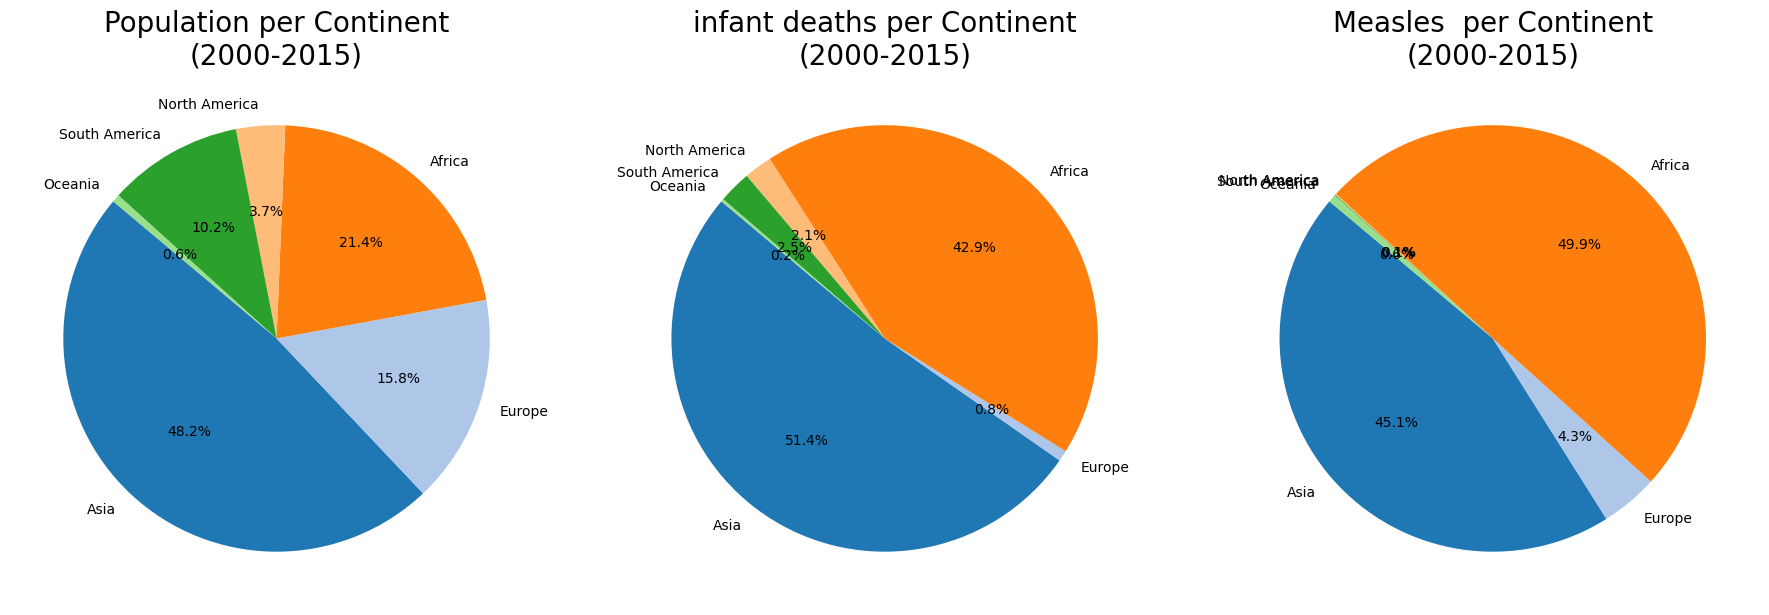

In [178]:
# developed = df[df['Status']=='Developed']
# developing = df[df['Status']=='Developing']
start_year = df['Year'].unique().min()
end_year = df['Year'].unique().max()

def generate_data_per_continent(df, param):
    data_per_continent = []
    for c in df['Continent'].unique():
        continent_data = df[df['Continent']==c][param]
        data_per_continent.append(continent_data.sum())
    return data_per_continent

params = [ 'Population', 'infant deaths', 'Measles ']

param0 = generate_data_per_continent(df, params[0])
param1 = generate_data_per_continent(df, params[1])
param2 = generate_data_per_continent(df, params[2])

# Set up subplots for 3 pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# List of parameter data for the plots
param_data = [param0, param1, param2]

# Create pie charts
for i, ax in enumerate(axes):
    ax.pie(param_data[i], labels=df['Continent'].unique(), autopct='%1.1f%%', 
           startangle=140, colors=plt.cm.tab20.colors)
    ax.set_title(f'{params[i]} per Continent\n({start_year}-{end_year})', fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()